In [2]:
import torch
import torch.nn as nn
import numpy as np

seed = 1
torch.manual_seed(seed)

class MLP(nn.Module):
    def __init__(self, width):
        super(MLP, self).__init__()
        depth = len(width) - 1
        self.depth = depth
        
        linears = []
        for i in range(depth):
            linears.append(nn.Linear(width[i], width[i+1]))
            
        self.linears = nn.ModuleList(linears)
        
    def forward(self, x):
        
        f = torch.nn.SiLU()
        for i in range(self.depth):
            x = self.linears[i](x)
            if i < self.depth - 1:
                x = f(x)
        return x
    
    
class Linear_Mask(nn.Module):
    def __init__(self, in_dim, out_dim, in_group=[], out_group=[]):
        super(Linear_Mask, self).__init__()
        assert np.sum(in_group) == in_dim
        assert np.sum(out_group) == out_dim
        assert len(in_group) == len(out_group)
        
        linear = nn.Linear(in_dim, out_dim)
        self.weight_unmask = linear.weight
        self.bias = linear.bias
        
        mask = torch.zeros(out_dim, in_dim)
        out_id = 0
        in_id = 0
        for i in range(len(in_group)):
            mask[out_id:out_id+out_group[i], in_id:in_id+in_group[i]] += 1.
            out_id += out_group[i]
            in_id += in_group[i]
            
        self.mask = mask
            
    @property
    def weight(self):
        return self.weight_unmask * self.mask
        
        
    def forward(self, x):
        return x @ self.weight.T + self.bias[None,:]
    
    

class MLP_Modular(nn.Module):
    def __init__(self):
        super(MLP_Modular, self).__init__()
        
        linears = []
        linears.append(Linear_Mask(2,100,in_group=[1,1], out_group=[50,50]))
        linears.append(Linear_Mask(100,100,in_group=[50,50], out_group=[50,50]))
        linears.append(Linear_Mask(100,2,in_group=[50,50], out_group=[1,1]))
            
        self.linears = nn.ModuleList(linears)
        self.depth = 3
        
    def forward(self, x):
        
        f = torch.nn.SiLU()
        for i in range(self.depth):
            x = self.linears[i](x)
            if i < self.depth - 1:
                x = f(x)
        return x
    
    
torch.manual_seed(seed)
np.random.seed(seed)
model = MLP(width = [2,100,100,2])
#model = MLP_Modular()

num = 1000
x = torch.rand(num,2) * 2 - 1
fraction = 0.01
task1_num = int(num * (1-fraction))
task2_num = num - task1_num
task1_id = np.random.choice(num, task1_num, replace=False)
task2_id = list(set(np.arange(num)) - set(task1_id))
x[task2_id,0] = 0.
x[task1_id,1] = 0.
target = x**2

mask = torch.zeros(num,2)
mask[task1_id, 0] = 1
mask[task2_id, 1] = 1

n_steps = 1000
log = 100

optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

losses_1 = []
losses_2 = []

for i in range(n_steps):

    optimizer.zero_grad()
    pred = model(x)
    
    loss = (pred-target)**2 * mask
    #loss_norm = loss / (loss**(-1) + 1e-4).detach()
    #loss_norm = loss / (loss**(1) + 1e-4).detach() * torch.mean(loss).detach()
    loss_norm = loss * loss.detach()/torch.mean(loss).detach()
    loss_norm = torch.mean(loss_norm)
    
    #loss += 1e-4
    #alpha = 2.
    #loss_norm = (torch.mean(loss**alpha))**(1/alpha)
    
    
    loss_norm.backward()
    
    #loss = torch.mean(loss)
    #loss.backward()
    optimizer.step()
    
    t1loss = torch.mean((pred-target)[task1_id,0]**2)
    t2loss = torch.mean((pred-target)[task2_id,1]**2)
    
    if i % log == 0:
        print('step = %d, task1 = %.2e, task2 = %.2e'%(i, t1loss.item(), t2loss.item()))
        
    losses_1.append(t1loss.item())
    losses_2.append(t2loss.item())
    
    

step = 0, task1 = 2.46e-01, task2 = 2.20e-01
step = 100, task1 = 6.14e-02, task2 = 9.36e-02
step = 200, task1 = 7.11e-04, task2 = 4.53e-02
step = 300, task1 = 8.59e-05, task2 = 1.07e-04


KeyboardInterrupt: 

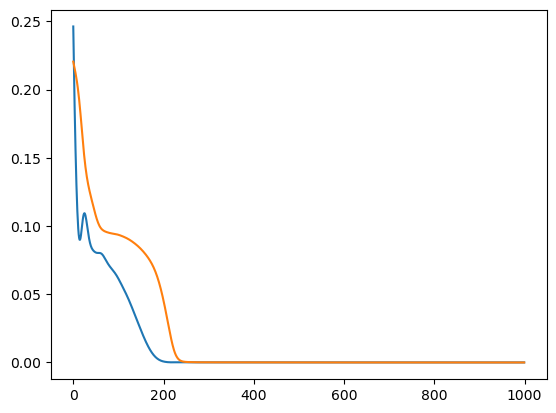

In [55]:
import matplotlib.pyplot as plt

plt.plot(losses_1)
plt.plot(losses_2)

In [11]:
def run(seed):
    print('seed = {}'.format(seed))

    model = MLP(width = [2,100,100,2])
    #model = MLP_Modular()

    num = 1000
    x = torch.rand(num,2) * 2 - 1
    fraction = 0.01
    task1_num = int(num * (1-fraction))
    task2_num = num - task1_num
    task1_id = np.random.choice(num, task1_num, replace=False)
    task2_id = list(set(np.arange(num)) - set(task1_id))
    x[task2_id,0] = 0.
    x[task1_id,1] = 0.
    target = x**2

    mask = torch.zeros(num,2)
    mask[task1_id, 0] = 1
    mask[task2_id, 1] = 1

    n_steps = 1000
    log = 100

    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

    losses_1 = []
    losses_2 = []

    for i in range(n_steps):

        optimizer.zero_grad()
        pred = model(x)

        loss = torch.mean((pred-target)**2*mask)
        loss.backward()
        optimizer.step()

        t1loss = torch.mean((pred-target)[task1_id,0]**2)
        t2loss = torch.mean((pred-target)[task2_id,1]**2)

        if i % log == 0:
            print('step = %d, task1 = %.2e, task2 = %.2e'%(i, t1loss.item(), t2loss.item()))

        losses_1.append(t1loss.item())
        losses_2.append(t2loss.item())


    th = 0.001
    try:
        t1_step = np.where(np.array(losses_1) < th)[0][0]
    except:
        t1_step = 1000
        
    try:
        t2_step = np.where(np.array(losses_2) < th)[0][0]
    except:
        t2_step = 1000
    print(f't1_step: {t1_step}, t2_step: {t2_step}')
    return t1_step, t2_step

t1_steps = []
t2_steps = []

for i in range(100):
    t1_step, t2_step = run(i)
    t1_steps.append(t1_step)
    t2_steps.append(t2_step)

seed = 0
step = 0, task1 = 2.54e-01, task2 = 2.97e-01
step = 100, task1 = 3.81e-02, task2 = 7.43e-02
step = 200, task1 = 2.69e-05, task2 = 5.15e-02
step = 300, task1 = 2.29e-05, task2 = 3.28e-02
step = 400, task1 = 2.21e-05, task2 = 1.32e-02
step = 500, task1 = 2.11e-05, task2 = 2.54e-03
step = 600, task1 = 1.98e-05, task2 = 3.50e-04
step = 700, task1 = 1.87e-05, task2 = 1.73e-04
step = 800, task1 = 1.78e-05, task2 = 1.54e-04
step = 900, task1 = 1.69e-05, task2 = 1.42e-04
t1_step: 151, t2_step: 545
seed = 1
step = 0, task1 = 2.30e-01, task2 = 2.99e-01
step = 100, task1 = 4.26e-02, task2 = 8.80e-02
step = 200, task1 = 1.02e-04, task2 = 5.48e-02
step = 300, task1 = 7.92e-05, task2 = 1.95e-02
step = 400, task1 = 6.65e-05, task2 = 1.61e-03
step = 500, task1 = 5.96e-05, task2 = 3.15e-05
step = 600, task1 = 5.48e-05, task2 = 1.86e-05
step = 700, task1 = 5.08e-05, task2 = 1.80e-05
step = 800, task1 = 4.72e-05, task2 = 1.72e-05
step = 900, task1 = 4.37e-05, task2 = 1.62e-05
t1_step: 152, t2_st

(0.0, 1000.0)

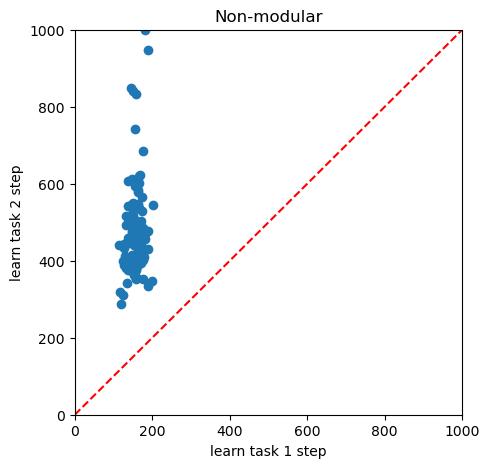

In [12]:
plt.figure(figsize=(5,5))

plt.scatter(t1_steps, t2_steps)
plt.plot([0,1000], [0,1000], ls='--', color='red')
plt.xlabel('learn task 1 step')
plt.ylabel('learn task 2 step')
plt.title('Non-modular')
plt.xlim(0,1000)
plt.ylim(0,1000)

# plot y = 2x
# learn task 1 is independent of task 2

(0.0, 1000.0)

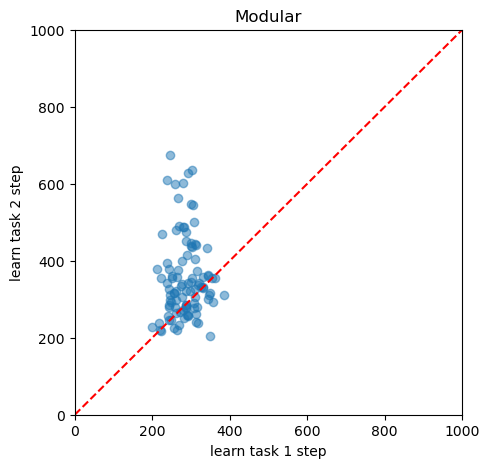

In [5]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5,5))

plt.scatter(t1_steps, t2_steps, alpha=0.5)
plt.plot([0,1000], [0,1000], ls='--', color='red')
plt.xlabel('learn task 1 step')
plt.ylabel('learn task 2 step')
plt.title('Modular')
plt.xlim(0,1000)
plt.ylim(0,1000)

In [13]:
results = {}
results['t1'] = np.array(t1_steps)
results['t2'] = np.array(t2_steps)

In [10]:
np.savez('./results/modularity_modular_MLP_2task', **results)

In [14]:
np.savez('./results/modularity_nonmodular_MLP_2task', **results)

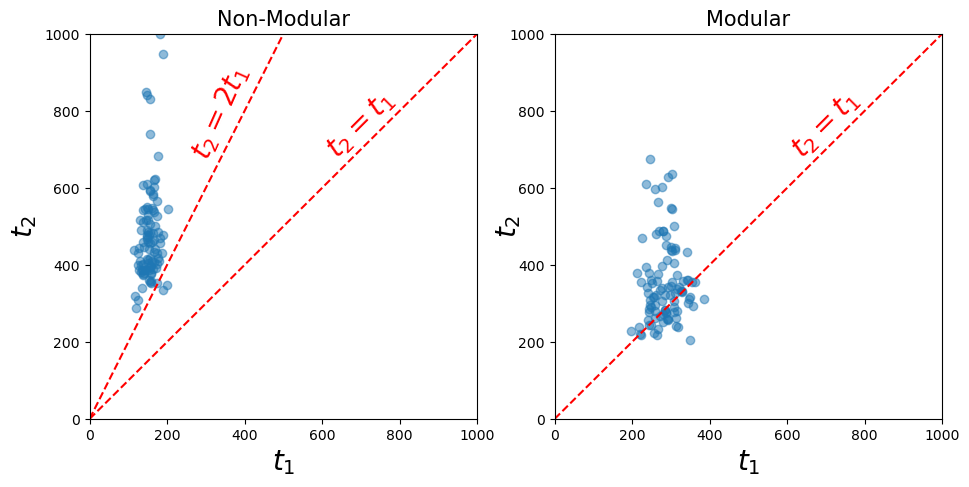

In [37]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(11,5))

fontsize = 20

plt.subplot(1,2,1)
dic = dict(np.load('./results/modularity_nonmodular_MLP_2task.npz'))
t1 = dic['t1']
t2 = dic['t2']
plt.scatter(t1, t2, alpha=0.5)
plt.plot([0,1000], [0,1000], ls='--', color='red')
plt.plot([0,500], [0,1000], ls='--', color='red')
plt.xlabel(r'$t_1$', fontsize=fontsize)
plt.ylabel(r'$t_2$', fontsize=fontsize)
plt.title('Non-Modular', fontsize=15)
plt.xlim(0,1000)
plt.ylim(0,1000)
plt.text(600,680,r'$t_2=t_1$', rotation=45, fontsize=fontsize, color='red')
plt.text(250,680,r'$t_2=2t_1$', rotation=66, fontsize=fontsize, color='red')

plt.subplot(1,2,2)
dic = dict(np.load('./results/modularity_modular_MLP_2task.npz'))
t1 = dic['t1']
t2 = dic['t2']
plt.scatter(t1, t2, alpha=0.5)
plt.plot([0,1000], [0,1000], ls='--', color='red')
plt.xlabel(r'$t_1$', fontsize=fontsize)
plt.ylabel(r'$t_2$', fontsize=fontsize, labelpad=-10)
plt.title('Modular', fontsize=15)
plt.xlim(0,1000)
plt.ylim(0,1000)
plt.text(600,680,r'$t_2=t_1$', rotation=45, fontsize=fontsize, color='red')
plt.savefig('./plot/modular_2task.pdf', bbox_inches='tight')